In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from src.mlhgp import MLHGP, HomGP
from src.imlhgp import IMLHGP
from src.nnpehgp import NNPEHGP
from src.kshgp import KSHGP
from src.ksmlhgp import KSMLHGP
from src.ksimlhgp import KSIMLHGP
from src.rnmlhgp import RNHGP as RNHGP2
from src.rnimlhgp import RNHGP as RNHGP3

## SUPPRESS ALL WARNINGS
import warnings

warnings.filterwarnings("ignore")

import scienceplots

plt.style.use('science')
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

## Toy function
Similar to (Makarova et al 2021)

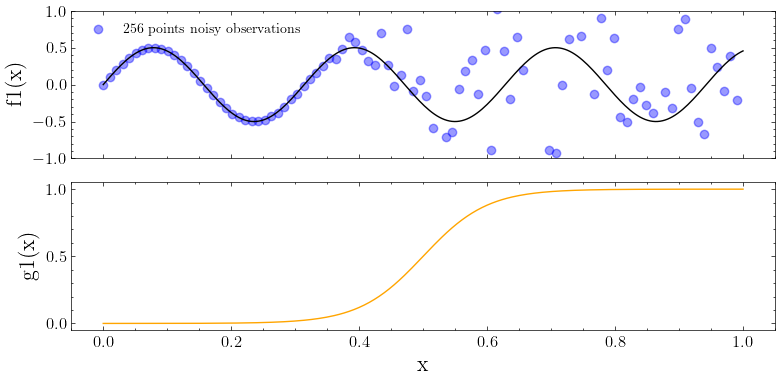

In [23]:
def g1(X):
    # logistic
    X = 20 * X - 10  # [0, 1] -> [-10, 10]
    return 1 / (1 + np.exp(-X))


def f1(X, add_noise=False):
    target = 0.5 * np.sin(X * 20)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(np.zeros_like(X), g1(X), size=target.shape)
    return target.squeeze()


x = np.linspace(-0, 1, 256)
x_noise = np.linspace(0, 1, 100)
y_noise = f1(x_noise, True)

# Create subplots: 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))  # 2 rows, 1 column

# Plot f1(x) in the first subplot
ax1.plot(x, f1(x), c="black")
ax1.scatter(x_noise, y_noise, alpha=0.4, label="256 points noisy observations", c="blue")
#ax1.set_title("Function f1(x)")
#ax1.set_xlabel("x")
ax1.set_ylabel("f1(x)")
ax1.set_ylim(-1., 1.)
ax1.legend()
ax1.xaxis.set_tick_params(labelbottom=False)

# Plot g1(x) in the second subplot
ax2.plot(x, g1(x), color="orange")
#ax2.set_title("Function g1(x)")
ax2.set_xlabel("x")
ax2.set_ylabel("g1(x)")
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.savefig("f1_g1.pdf")

# Show plot
plt.show()

## Modeling

In [3]:
# Plan to use a similar acquisition function as described in Makarova et al.

# Define initial grid and observed data
x_init = np.linspace(0, 1, 200).reshape(
    -1, 1
)  # Generate initial input space over the interval [0, 1]
y_init = f1(x_init, True)  # Generate initial observations with noise

# Initialize Heterogeneous Gaussian Process (HGP) model
hgp = KSMLHGP

base_kernel = ConstantKernel(1.0) * RBF(
    length_scale=0.1, length_scale_bounds=(0.01, 100)
) + WhiteKernel(noise_level=1, noise_level_bounds=(0.001, 10))
noise_kernel = ConstantKernel(1.0) * RBF(
    length_scale=0.1, length_scale_bounds=(0.01, 100)
) + WhiteKernel(noise_level=1, noise_level_bounds=(0.001, 10))

gp = GaussianProcessRegressor(kernel=base_kernel, n_restarts_optimizer=25)
gp_noise = GaussianProcessRegressor(kernel=noise_kernel, n_restarts_optimizer=25)

model_hgp = hgp(model=gp, model_noise=gp_noise)

# Fit the HGP model
model_hgp.fit(x_init.reshape(-1, 1), y_init.reshape(-1, 1).flatten())

Y_pred, Std_pred = model_hgp.predict(x_noise.reshape(-1, 1), return_std="multi")
std_al, std_ep = Std_pred

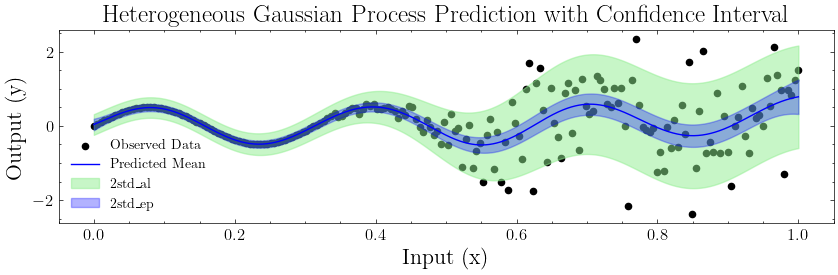

In [4]:
# Plot predictions
plt.figure(figsize=(10, 2.5))

# Scatter plot of observed data
plt.scatter(x_init, y_init, color="black", label="Observed Data", s=20)

# Plot predicted mean
plt.plot(x_noise, Y_pred, color="blue", label="Predicted Mean")

# Fill between for standard deviation
plt.fill_between(
    x_noise.flatten(),
    (Y_pred - 2 * std_al).flatten(),
    (Y_pred + 2 * std_al).flatten(),
    color="lightgreen",
    alpha=0.5,
    label="2std_al",
)

plt.fill_between(
    x_noise.flatten(),
    (Y_pred - 2 * std_ep).flatten(),
    (Y_pred + 2 * std_ep).flatten(),
    color="blue",
    alpha=0.3,
    label="2std_ep",
)

# Adding labels and title
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.title("Heterogeneous Gaussian Process Prediction with Confidence Interval")
plt.legend()
plt.show()

## TODO: BO STUFF

In [5]:
from src.bo import (
    BayesianOptimizer,
    AugmentedEIAcqFunction,
    RAHBOAcqFunction,
    CMAESAcqOptimizer,
    RandomAcqOptimizer,
)

# sample initial observations

true_function = f1
bounds = np.array([[0], [1]])  # [2, D]
xdim = bounds.shape[1]  # [D]
n_init = 3 * xdim + 1
x_init = np.random.uniform(bounds[0], bounds[1], (n_init, bounds.shape[1]))
y_init = true_function(x_init, add_noise=True)

init_dataset = {"X": x_init, "y": y_init}

# Define model
hgp = KSMLHGP

base_kernel = ConstantKernel(1.0) * RBF(
    length_scale=0.1, length_scale_bounds=(0.01, 100)
) + WhiteKernel(noise_level=1, noise_level_bounds=(0.001, 10))
noise_kernel = ConstantKernel(1.0) * RBF(
    length_scale=0.1, length_scale_bounds=(0.01, 100)
) + WhiteKernel(noise_level=1, noise_level_bounds=(0.001, 10))

gp = GaussianProcessRegressor(kernel=base_kernel, n_restarts_optimizer=25)
gp_noise = GaussianProcessRegressor(kernel=noise_kernel, n_restarts_optimizer=25)

model_hgp = hgp(model=gp, model_noise=gp_noise)

# Fit the HGP model
model_hgp.fit(init_dataset["X"], init_dataset["y"])

model = model_hgp

acq_f = RAHBOAcqFunction(alpha=0.1, beta=0.5)
bo_optimizer = RandomAcqOptimizer(n_candidates=10000, bounds=bounds)
bo = BayesianOptimizer(
    model=model,
    acquisition_function=acq_f,
    true_function=f1,
    acq_optimizer=bo_optimizer,
)

# Run BO
result = bo.optimize(init_dataset, n_iter=30)


# Plot results
# TODO: plot results
# plot not only optimum eval but also consider noise

KeyboardInterrupt: 

In [6]:
x_init = np.linspace(0, 1, 200).reshape(
    -1, 1
)  # Generate initial input space over the interval [0, 1] and reshape to [200, 1]
y_init = f1(x_init, True)  # Generate initial observations with noise